# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
import ast
import re
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer

C:\Users\dom\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Functions

In [2]:
#Function that writes to csv
def saveData(x):
    x.to_csv('dataintermediate.csv',index=False)

In [3]:
#find any of specific substrings 
def substringExists(x,strlist):
    """if any of folling values appears return 1"""
    if any(re.findall('|'.join(strlist),x)):
        return 1
    return x

# Data preparation

### Read Data and select columns for Model

In [4]:
df=pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [5]:
#First I will use most commonsence properties that might influence the property Price
data=df[['status','private pool','baths','homeFacts','fireplace','schools','sqft','beds','state','stories','PrivatePool','propertyType','target']]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   baths         270847 non-null  object
 3   homeFacts     377185 non-null  object
 4   fireplace     103115 non-null  object
 5   sqft          336608 non-null  object
 6   beds          285903 non-null  object
 7   state         377185 non-null  object
 8   stories       226470 non-null  object
 9   PrivatePool   40311 non-null   object
 10  propertyType  342452 non-null  object
 11  target        374704 non-null  object
dtypes: object(12)
memory usage: 34.5+ MB


## HomeFacts

In [7]:
data['homeFacts']=data['homeFacts'].apply(lambda x: ast.literal_eval(x)['atAGlanceFacts'])


In [8]:
#Get Labels for df columns
def getdata(x):
    Labels=list()
    for i in x:
        Labels.append(i['factLabel'])
    return Labels
Labels=getdata(data.homeFacts[1])
Labels

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [9]:
#Convert dictionaries per row to appropriate columns in df and extract all the values
for l in Labels:
    data[l]=data['homeFacts'].apply(lambda x: x[Labels.index(l)]['factValue']) 

## Schools

In [7]:
data['schools']=data['schools'].apply(lambda x: ast.literal_eval(x)['atAGlanceFacts'])


In [8]:
#Get Labels for df columns
def getdata(x):
    Labels=list()
    for i in x:
        Labels.append(i['factLabel'])
    return Labels
Labels=getdata(data.homeFacts[1])
Labels

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [9]:
#Convert dictionaries per row to appropriate columns in df and extract all the values
for l in Labels:
    data[l]=data['homeFacts'].apply(lambda x: x[Labels.index(l)]['factValue']) 

### Fill nas in sqft with existing lotsize values

In [10]:
data.lotsize=data.lotsize.str.lower().str.strip()
#Remove all acre substrings and convert the values to float and fill na of sqft with values
data.sqft[(data.sqft.isna()==True)&(data.lotsize.str.contains('acre'))]=data.lotsize[(data.sqft.isna()==True)&(data.lotsize.str.contains('acre'))].str.replace(' acres','').str.replace(',','').str.replace(' acre','').astype(float)*43560.04

In [11]:
#Remove all sq substrings and convert the values to float and fill na of sqft with values
data.sqft[(data.sqft.isna()==True)&(data.lotsize.str.contains('sq'))]=data.lotsize[(data.sqft.isna()==True)&(data.lotsize.str.contains('sq'))].str.replace(' sq. ft.','').str.replace(',','').str.replace(' sqft','').astype(float)*43560.04

## Price/sqft

In [12]:
data['Price/sqft']=data['Price/sqft'].str.lower()

In [13]:
data['Price/sqft'][(data['Price/sqft'].str.contains('$')==True)&(data['Price/sqft'].isna()==False)]=data['Price/sqft'][(data['Price/sqft'].str.contains('$')==True)&(data['Price/sqft'].isna()==False)].str.replace('$','')
data['Price/sqft'][(data['Price/sqft'].str.contains('sq')==True)&(data['Price/sqft'].isna()==False)]=data['Price/sqft'][(data['Price/sqft'].str.contains('sq')==True)&(data['Price/sqft'].isna()==False)].str.replace('/sqft','').str.replace(' / sq. ft.','')
data['Price/sqft'][(data['Price/sqft'].str.contains('no')==True)&(data['Price/sqft'].isna()==False)]=data['Price/sqft'][(data['Price/sqft'].str.contains('no')==True)&(data['Price/sqft'].isna()==False)].str.replace('no data','none').str.replace('no info','none')
data['Price/sqft'][(data['Price/sqft'].str.contains(',')==True)&(data['Price/sqft'].isna()==False)]=data['Price/sqft'][(data['Price/sqft'].str.contains(',')==True)&(data['Price/sqft'].isna()==False)].str.replace(',','')
data['Price/sqft'][(data['Price/sqft'].str.contains('contact manager')==True)&(data['Price/sqft'].isna()==False)]=data['Price/sqft'][(data['Price/sqft'].str.contains('contact manager')==True)&(data['Price/sqft'].isna()==False)].str.replace('contact manager','none')
data['Price/sqft'][(data['Price/sqft']=='')&(data['Price/sqft'].isna()==False)]='none'

In [14]:
data['Price/sqft'][(data['Price/sqft']!='none')&(data['Price/sqft'].isna()==False)]=data['Price/sqft'][(data['Price/sqft']!='none')&(data['Price/sqft'].isna()==False)].astype(float)
data['Price/sqft']

0          144
1          159
2          965
3          371
4         None
          ... 
377180     311
377181     337
377182     458
377183    None
377184     140
Name: Price/sqft, Length: 377185, dtype: object

### Price of the Property (target) 

In [15]:
#find symbols that are not numbers to replace

symbollist=data.target.str.findall(r'\D').value_counts().reset_index()['index']
s=list()
for i in symbollist:
    s=s+i
s=list(set(s))
s=''.join(s)
s

'+ o-$/m,'

In [16]:
#Function that First remove ",","+","/mo" from all string values then If the string value is a range - take the average
#Function returns for strings it's numeric value
def clean_currency(x):
    """replace redundent symbols"""
    if isinstance(x, str):
        x=x.replace('$','').replace(',','').replace('+','').replace('/mo','')
      
    #for values that appears as range take the average
    if isinstance(x, str) and x.find(' - ')>0:
        a=x.find(' - ')
        return((float(x[:a])+float(x[a+3:]))/2)  
    return(float(x))

In [17]:
data['target'] = data['target'].apply(clean_currency)
data=data.rename(columns={'target':'Price'})

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          337267 non-null  object 
 1   private pool    4181 non-null    object 
 2   baths           270847 non-null  object 
 3   homeFacts       377185 non-null  object 
 4   fireplace       103115 non-null  object 
 5   sqft            362944 non-null  object 
 6   beds            285903 non-null  object 
 7   state           377185 non-null  object 
 8   stories         226470 non-null  object 
 9   PrivatePool     40311 non-null   object 
 10  propertyType    342452 non-null  object 
 11  Price           374704 non-null  float64
 12  Year built      373572 non-null  object 
 13  Remodeled year  350616 non-null  object 
 14  Heating         373652 non-null  object 
 15  Cooling         373652 non-null  object 
 16  Parking         373652 non-null  object 
 17  lotsize   

## sqft

In [19]:
#use Area data for filling NAs for sqft
values=data['beds'][data.beds.str.contains('sqft')==True]
valuesA=data['beds'][data.beds.str.contains('acres')==True]
data['sqft'][data.beds.str.contains('sqft')==True]=values
data['sqft'][data.beds.str.contains('acres')==True]=valuesA
data[['beds','sqft']][(data.beds.str.contains('sqft|acres')==True)]
data['beds'][data.beds.str.contains('sqft|arcres')==True]='None'

In [20]:
data.sqft[data.sqft.str.contains(' sqft|,')==True]=data.sqft[data.sqft.str.contains(' sqft|,')==True].str.replace(' sqft','').str.replace(',','')
data.sqft[data.sqft.str.contains('acre')==True]=data.sqft[data.sqft.str.contains('acre')==True].str.replace(' acres','').astype(float)*43560.04
data.sqft[(data.sqft.str.contains('\D')==True)&(data.sqft.isna()==False)]=data.sqft[(data.sqft.str.contains('\D')==True)&(data.sqft.isna()==False)].str.replace('\D','')
#fill blank with mean of non blank
data.sqft[(data.sqft.isna()==False)&(data.sqft=='')]=data.sqft[(data.sqft.isna()==False)&(data.sqft!='')].astype(float).mean()
data.sqft[(data.sqft.isna()==False)]=data.sqft[(data.sqft.isna()==False)].astype(float)

In [21]:
#Group data according to property type and take the average area for each property type for NA
Area=data[['sqft','propertyType']]
Area['sqft']=Area['sqft'][Area.sqft.isna()==False].astype(float)
Area=Area[Area.sqft.isna()==False].groupby(by='propertyType').mean().reset_index()
Area.sqft=Area.sqft.round(decimals=0)
data.sqft[data.sqft.isna()==True]=data[data.sqft.isna()==True].merge(Area, on='propertyType', how='left').sqft_y


### Use Price, sqft and Price/sqft to fill na's

In [22]:
#replace sqft nas with [Price]/[Price/sqft]
data1=data[['Price/sqft','sqft','Price']][(data.sqft.isna()==True)&(data['Price/sqft'].isna()==False)&(data.Price.isna()==False)&(data['Price/sqft']!='none')]
data1.sqft=data1.Price/data1['Price/sqft']
data['sqft'].iloc[data1.index]=data1.sqft

In [23]:
#replace Price nas with [sqft]*[Price/sqft]
data1=data[['Price/sqft','sqft','Price']][((data.Price.isna()==True)&data.sqft.isna()==False)&(data['Price/sqft'].isna()==False)&(data['Price/sqft']!='none')]
data1.Price=data1.sqft*data1['Price/sqft']
data['Price'].iloc[data1.index]=data1.Price
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   status          337267 non-null  object
 1   private pool    4181 non-null    object
 2   baths           270847 non-null  object
 3   homeFacts       377185 non-null  object
 4   fireplace       103115 non-null  object
 5   sqft            366397 non-null  object
 6   beds            285903 non-null  object
 7   state           377185 non-null  object
 8   stories         226470 non-null  object
 9   PrivatePool     40311 non-null   object
 10  propertyType    342452 non-null  object
 11  Price           375054 non-null  object
 12  Year built      373572 non-null  object
 13  Remodeled year  350616 non-null  object
 14  Heating         373652 non-null  object
 15  Cooling         373652 non-null  object
 16  Parking         373652 non-null  object
 17  lotsize         348797 non-nu

In [24]:
data.drop(['Price/sqft','lotsize'],axis=1,inplace=True)

### Get rid of the rows where Price and sqft is NA

In [25]:
data.dropna(subset=['sqft'],axis=0,inplace=True)
data.dropna(subset=['Price'],axis=0,inplace=True)

In [26]:
data.sqft=data.sqft.astype(float)
data.Price=data.Price.astype(float)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364386 entries, 0 to 377184
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          325156 non-null  object 
 1   private pool    4151 non-null    object 
 2   baths           267791 non-null  object 
 3   homeFacts       364386 non-null  object 
 4   fireplace       102413 non-null  object 
 5   sqft            364386 non-null  float64
 6   beds            281456 non-null  object 
 7   state           364386 non-null  object 
 8   stories         224449 non-null  object 
 9   PrivatePool     40004 non-null   object 
 10  propertyType    337418 non-null  object 
 11  Price           364386 non-null  float64
 12  Year built      360884 non-null  object 
 13  Remodeled year  338198 non-null  object 
 14  Heating         360960 non-null  object 
 15  Cooling         360960 non-null  object 
 16  Parking         360960 non-null  object 
dtypes: float64

In [28]:
#data.to_csv('dataintermediate.csv',index=False)
saveData(data)

In [29]:
data=pd.read_csv('dataintermediate.csv')
data.iloc[4]

status                                                     for sale
private pool                                                    NaN
baths                                                           NaN
homeFacts         [{'factValue': '', 'factLabel': 'Year built'},...
fireplace                                                       NaN
sqft                                                    4.36428e+08
beds                                                            NaN
state                                                            FL
stories                                                         NaN
PrivatePool                                                     NaN
propertyType                                               lot/land
Price                                                          5000
Year built                                                      NaN
Remodeled year                                                  NaN
Heating                                         

## Year built and remodeled

In [30]:
data=pd.read_csv('dataintermediate.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364386 entries, 0 to 364385
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          325156 non-null  object 
 1   private pool    4151 non-null    object 
 2   baths           267791 non-null  object 
 3   homeFacts       364386 non-null  object 
 4   fireplace       102413 non-null  object 
 5   sqft            364386 non-null  float64
 6   beds            281456 non-null  object 
 7   state           364386 non-null  object 
 8   stories         224449 non-null  object 
 9   PrivatePool     40004 non-null   object 
 10  propertyType    337418 non-null  object 
 11  Price           364386 non-null  float64
 12  Year built      310492 non-null  object 
 13  Remodeled year  149361 non-null  float64
 14  Heating         264567 non-null  object 
 15  Cooling         250334 non-null  object 
 16  Parking         199711 non-null  object 
dtypes: float64

In [31]:
#put indexes of str and num values in to variables
stri=data['Year built'][data['Year built'].str.contains('\D')==True].index
numi=data['Year built'][data['Year built'].str.contains('\D')==False].index

In [32]:
#replace exeptions where there is no sence (smaller than 0 or bigger than 2020) by No Data
iyearexp=data['Year built'].iloc[numi].astype('int64')[(data['Year built'].iloc[numi].astype('int64')<0)|(data['Year built'].iloc[numi].astype('int64')>2020)].index
data['Year built'].iloc[iyearexp]='No Data'
numi=data['Year built'][data['Year built'].str.contains('\D')==False].index
stri=data['Year built'][data['Year built'].str.contains('\D')==True].index

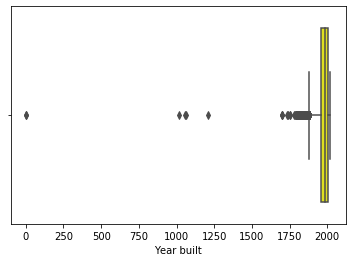

In [33]:
#Check if there are more exeptions
sns.boxplot(data['Year built'].iloc[numi].astype('int64'), color='yellow');

In [34]:
#Drop more exeptions values that smaller than 1500 -> update number indexes value
iyearexp=data['Year built'].iloc[numi].astype('int64')[(data['Year built'].iloc[numi].astype('int64')<1500)|(data['Year built'].iloc[numi].astype('int64')>2020)].index
data['Year built'].iloc[iyearexp]='No Data'
numi=data['Year built'][data['Year built'].str.contains('\D')==False].index
stri=data['Year built'][data['Year built'].str.contains('\D')==True].index

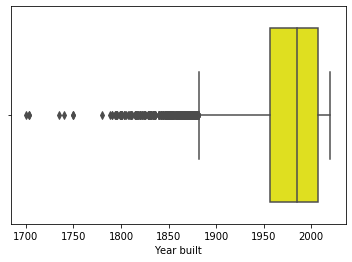

In [35]:
sns.boxplot(data['Year built'].iloc[numi].astype('int64'), color='yellow');

In [36]:
#convert numeric data to integer
data['Year built'].iloc[numi]=data['Year built'].iloc[numi].astype(int)

In [37]:
#replace string data to mean of numeric data
data['Year built'].iloc[stri]=int(round(data['Year built'].iloc[numi].mean(),0))

In [38]:
#fill nas with the mean of numeric values
data['Year built'].fillna(int(round(data['Year built'].iloc[numi].mean(),0)),inplace=True)

In [39]:
data['Year built'].describe()

count    364386.000000
mean       1979.280332
std          30.923218
min        1700.000000
25%        1962.000000
50%        1979.000000
75%        2005.000000
max        2020.000000
Name: Year built, dtype: float64

In [40]:
data['Remodeled year'].fillna(data['Remodeled year'].notnull().mean(),inplace=True)
data['Remodeled year']=data['Remodeled year'].astype(int)

### Status

In [41]:
data.status=data.status.str.lower()
status=data.status
status=status.value_counts(normalize=True).reset_index()
status
#according to next summary I would use only for sale, active, accepted for status(that are 91% of overall amount), the rest will be dropped

,index,status
0,for sale,0.607195
1,active,0.298552
2,foreclosure,0.018330
3,new construction,0.016783
4,pending,0.014756
...,...,...
145,coming soon: nov 23.,0.000003
146,pending - backup offer requested,0.000003
147,coming soon: nov 17.,0.000003
148,pending w/escape clause,0.000003


In [42]:
strlist=['for sale','active','accepted']
status['newStatus']=status['index'].apply(lambda x: substringExists(x,strlist))
nstatus=status.groupby('newStatus').sum().reset_index()
nstatus

,newStatus,status
0,1,0.909902
1,/ auction,0.002454
2,accepting backups,0.000006
3,apartment for rent,0.000022
4,auction,0.001489
...,...,...
128,under contract - show,0.000028
129,under contract backups,0.000775
130,under contract show,0.003638
131,under contract taking back up offers,0.000003


In [43]:
#create list of statuses that are not relevant and then drop them from df
nstatus=status[status['newStatus']!=1]['newStatus']
nstatus.tolist()

['foreclosure',
 'new construction',
 'pending',
 'pre-foreclosure',
 'p',
 'pre-foreclosure / auction',
 'under contract show',
 ' / auction',
 'under contract   showing',
 'under contract',
 'new',
 'contingent',
 'price change',
 'auction',
 'for rent',
 'foreclosed',
 'recently sold',
 'under contract backups',
 'contingent finance and inspection',
 'pending continue to show',
 'back on market',
 'option pending',
 'contingent show',
 'pending taking backups',
 'option contract',
 'pending with contingencies',
 'c',
 'contract p',
 'pi',
 'p pending sale',
 'due diligence period',
 'contract contingent on buyer sale',
 'listing extended',
 'c continue show',
 'pending - taking backups',
 'closed',
 'offer pending signature',
 'pending inspection',
 'contingent take backup',
 'contingent   show',
 'pending in',
 'u under contract',
 'coming soon: nov 29.',
 'contingent escape',
 'pending w/insp finance',
 'under contract - show',
 'contingency contract',
 'ct insp - inspection conti

In [44]:
data.drop(data[data['status'].isin(nstatus)==True].index.values.tolist(),inplace=True)
data=data.reset_index()
data.drop(['index'],axis=1,inplace=True)
data.drop(['status'],axis=1,inplace=True)
data.head()

,private pool,baths,homeFacts,fireplace,sqft,beds,state,stories,PrivatePool,propertyType,Price,Year built,Remodeled year,Heating,Cooling,Parking
0,NaN,3.5,"[{'factValue': '2019', 'factLabel': 'Year buil...",Gas Logs,2.900000e+03,4,NC,NaN,NaN,Single Family Home,417600.0,2019,0,"Central A/C, Heat Pump",NaN,NaN
1,NaN,3 Baths,"[{'factValue': '2019', 'factLabel': 'Year buil...",NaN,1.947000e+03,3 Beds,WA,2.0,NaN,single-family home,309573.0,2019,0,NaN,NaN,NaN
2,NaN,2 Baths,"[{'factValue': '1961', 'factLabel': 'Year buil...",yes,3.000000e+03,3 Beds,CA,1.0,yes,single-family home,2895000.0,1961,1967,Forced Air,Central,Attached Garage
3,NaN,8 Baths,"[{'factValue': '2006', 'factLabel': 'Year buil...",yes,6.457000e+03,5 Beds,TX,3.0,NaN,single-family home,2395547.0,2006,2006,Forced Air,Central,Detached Garage
4,NaN,NaN,"[{'factValue': '', 'factLabel': 'Year built'},...",NaN,4.364280e+08,NaN,FL,NaN,NaN,lot/land,5000.0,1979,0,NaN,NaN,NaN


### Private Pool

In [45]:
data['PrivatePool']=data['PrivatePool'].str.lower()
data['private pool']=data['private pool'].str.lower()

In [46]:
# Replace 'yes' with 1 and unufy "private pool" and PrivatePool and replace NA with 0
data[['private pool','PrivatePool']]=data[['private pool','PrivatePool']].replace(to_replace=['yes'],value=1)
data['PrivatePool']=data['PrivatePool'].fillna(data['private pool'])
data['PrivatePool']=data['PrivatePool'].fillna(0)
data=data.drop(['private pool'],axis=1)


In [47]:
data.PrivatePool=data.PrivatePool.astype(int)
data.PrivatePool.value_counts()

0    292269
1     42821
Name: PrivatePool, dtype: int64

In [48]:
data.head()

,baths,homeFacts,fireplace,sqft,beds,state,stories,PrivatePool,propertyType,Price,Year built,Remodeled year,Heating,Cooling,Parking
0,3.5,"[{'factValue': '2019', 'factLabel': 'Year buil...",Gas Logs,2.900000e+03,4,NC,NaN,0,Single Family Home,417600.0,2019,0,"Central A/C, Heat Pump",NaN,NaN
1,3 Baths,"[{'factValue': '2019', 'factLabel': 'Year buil...",NaN,1.947000e+03,3 Beds,WA,2.0,0,single-family home,309573.0,2019,0,NaN,NaN,NaN
2,2 Baths,"[{'factValue': '1961', 'factLabel': 'Year buil...",yes,3.000000e+03,3 Beds,CA,1.0,1,single-family home,2895000.0,1961,1967,Forced Air,Central,Attached Garage
3,8 Baths,"[{'factValue': '2006', 'factLabel': 'Year buil...",yes,6.457000e+03,5 Beds,TX,3.0,0,single-family home,2395547.0,2006,2006,Forced Air,Central,Detached Garage
4,NaN,"[{'factValue': '', 'factLabel': 'Year built'},...",NaN,4.364280e+08,NaN,FL,NaN,0,lot/land,5000.0,1979,0,NaN,NaN,NaN


### Bath

In [49]:
data.baths=data.baths.str.lower()
print(f'There are {round(data.baths.isna().sum()/data.baths.count()*100,0)}% missing values')

There are 38.0% missing values


In [50]:
#Leave cells with numbers only for Bath 
data['baths']=data.baths.str.findall(r'\d').str[0]

In [51]:
data['baths'][data.baths.isna()==False]=data['baths'][data.baths.isna()==False].astype(int)

In [52]:
data.baths.value_counts(normalize=True)

2.0    0.437647
3.0    0.274363
4.0    0.106996
1.0    0.093295
5.0    0.038813
6.0    0.017565
0.0    0.014929
7.0    0.009527
8.0    0.004650
9.0    0.002215
Name: baths, dtype: float64

In [53]:
#Group data according to property type and take the average bathrooms for each property type for NA
Baths=data[['baths','propertyType']]
Baths['baths']=Baths['baths'][Baths.baths.isna()==False].astype(int)
Baths=Baths[Baths.baths.isna()==False].groupby(by='propertyType').mean().reset_index()
Baths.baths=Baths.baths.round(decimals=0)
data.baths[data.baths.isna()==True]=data[data.baths.isna()==True].merge(Baths, on='propertyType', how='left').baths_y
data

,baths,homeFacts,fireplace,sqft,beds,state,stories,PrivatePool,propertyType,Price,Year built,Remodeled year,Heating,Cooling,Parking
0,3,"[{'factValue': '2019', 'factLabel': 'Year buil...",Gas Logs,2.900000e+03,4,NC,NaN,0,Single Family Home,417600.0,2019,0,"Central A/C, Heat Pump",NaN,NaN
1,3,"[{'factValue': '2019', 'factLabel': 'Year buil...",NaN,1.947000e+03,3 Beds,WA,2.0,0,single-family home,309573.0,2019,0,NaN,NaN,NaN
2,2,"[{'factValue': '1961', 'factLabel': 'Year buil...",yes,3.000000e+03,3 Beds,CA,1.0,1,single-family home,2895000.0,1961,1967,Forced Air,Central,Attached Garage
3,8,"[{'factValue': '2006', 'factLabel': 'Year buil...",yes,6.457000e+03,5 Beds,TX,3.0,0,single-family home,2395547.0,2006,2006,Forced Air,Central,Detached Garage
4,2,"[{'factValue': '', 'factLabel': 'Year built'},...",NaN,4.364280e+08,NaN,FL,NaN,0,lot/land,5000.0,1979,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335085,6,"[{'factValue': '1990', 'factLabel': 'Year buil...",NaN,4.017000e+03,5,FL,0.0,1,Single Family,1249287.0,1990,1990,Other,Central,2 spaces
335086,3,"[{'factValue': '1924', 'factLabel': 'Year buil...",NaN,2.000000e+03,3 Beds,IL,9.0,0,condo,674000.0,1924,0,Radiant,NaN,None
335087,3,"[{'factValue': '1950', 'factLabel': 'Year buil...",NaN,1.152000e+03,3 Beds,NY,2,0,single-family home,527616.0,1950,1950,Other,NaN,2
335088,NaN,"[{'factValue': None, 'factLabel': 'Year built'...",NaN,8.479000e+03,None,TX,NaN,0,NaN,34500.0,1979,0,NaN,NaN,NaN


In [54]:
#Group data according to bedrooms and take the average bathrooms for each bedroom number for NA
BathsBeds=data[['baths','beds']]
BathsBeds['baths']=BathsBeds['baths'][BathsBeds.baths.isna()==False].astype(int)
BathsBeds=BathsBeds[BathsBeds.baths.isna()==False].groupby(by='beds').mean().reset_index()
BathsBeds.baths=BathsBeds.baths.round(decimals=0)
data.baths[data.baths.isna()==True]=data[data.baths.isna()==True].merge(BathsBeds, on='beds', how='left').baths_y
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335090 entries, 0 to 335089
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           262393 non-null  object 
 1   homeFacts       335090 non-null  object 
 2   fireplace       93537 non-null   object 
 3   sqft            335090 non-null  float64
 4   beds            254585 non-null  object 
 5   state           335090 non-null  object 
 6   stories         204724 non-null  object 
 7   PrivatePool     335090 non-null  int32  
 8   propertyType    308389 non-null  object 
 9   Price           335090 non-null  float64
 10  Year built      335090 non-null  int64  
 11  Remodeled year  335090 non-null  int32  
 12  Heating         243415 non-null  object 
 13  Cooling         231854 non-null  object 
 14  Parking         181781 non-null  object 
dtypes: float64(2), int32(2), int64(1), object(10)
memory usage: 35.8+ MB


In [55]:
#check if some values can be taken from beds column
data['beds'][(data.beds.str.contains('Bath'))&(data.beds.isna()==False)&(data.baths.isna()==True)]

107        Bath
197        Bath
791       Baths
2023      Baths
2260       Bath
          ...  
333570    Baths
333772    Baths
334311    Baths
334452    Baths
334602    Baths
Name: beds, Length: 877, dtype: object

In [56]:
#beds columns has values that contains baths, replace NA with 1 for bath and 2 for baths
data['beds'][(data.beds=='Bath')&(data.beds.isna()==False)&(data.baths.isna()==True)]=1
data['beds'][(data.beds=='Baths')&(data.beds.isna()==False)&(data.baths.isna()==True)]=2
data['baths'][(data.beds.str.contains('Bath'))&(data.beds.isna()==False)&(data.baths.isna()==True)]=1

In [57]:
#Group data according to sqft and take the average bathrooms for each area for NA
BathsArea=data[['baths','sqft']]
BathsArea['baths']=BathsArea['baths'][BathsArea.baths.isna()==False].astype(int)
BathsArea=BathsArea[BathsArea.baths.isna()==False].groupby(by='sqft').mean().reset_index()
BathsArea.baths=BathsArea.baths.round(decimals=0)
data.baths[data.baths.isna()==True]=data[data.baths.isna()==True].merge(BathsArea, on='sqft', how='left').baths_y
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335090 entries, 0 to 335089
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           266208 non-null  object 
 1   homeFacts       335090 non-null  object 
 2   fireplace       93537 non-null   object 
 3   sqft            335090 non-null  float64
 4   beds            254585 non-null  object 
 5   state           335090 non-null  object 
 6   stories         204724 non-null  object 
 7   PrivatePool     335090 non-null  int32  
 8   propertyType    308389 non-null  object 
 9   Price           335090 non-null  float64
 10  Year built      335090 non-null  int64  
 11  Remodeled year  335090 non-null  int32  
 12  Heating         243415 non-null  object 
 13  Cooling         231854 non-null  object 
 14  Parking         181781 non-null  object 
dtypes: float64(2), int32(2), int64(1), object(10)
memory usage: 35.8+ MB


In [58]:
data.baths.fillna(1,inplace=True)
data.baths=data.baths.astype(int)

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335090 entries, 0 to 335089
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           335090 non-null  int32  
 1   homeFacts       335090 non-null  object 
 2   fireplace       93537 non-null   object 
 3   sqft            335090 non-null  float64
 4   beds            254585 non-null  object 
 5   state           335090 non-null  object 
 6   stories         204724 non-null  object 
 7   PrivatePool     335090 non-null  int32  
 8   propertyType    308389 non-null  object 
 9   Price           335090 non-null  float64
 10  Year built      335090 non-null  int64  
 11  Remodeled year  335090 non-null  int32  
 12  Heating         243415 non-null  object 
 13  Cooling         231854 non-null  object 
 14  Parking         181781 non-null  object 
dtypes: float64(2), int32(3), int64(1), object(9)
memory usage: 34.5+ MB


### Beds

In [60]:
data.beds=data.beds.str.lower()
print(f'There are {round(data.beds.isna().sum()/data.baths.count()*100,0)}% of missing values')

There are 24.0% of missing values


In [61]:
data.beds.value_counts(normalize=True)

3 beds        0.196966
4 beds        0.133453
3             0.108303
2 beds        0.097377
4             0.069771
                ...   
6.28 acres    0.000004
1.57 acres    0.000004
8.43 acres    0.000004
3.62 acres    0.000004
5.8 acres     0.000004
Name: beds, Length: 581, dtype: float64

In [62]:
#leave numbers only for Beds
data['beds']=data.beds.str.replace(' beds','').str.replace(' bd','')
data['beds']=data.beds.str.replace('baths','2')
data['beds']=data.beds.str.replace('bath','1')
data.beds[(data.beds.str.contains('\D')==True)&(data.beds.isna()==False)].value_counts(normalize=True)

3.0                                                                                                                           0.342497
4.0                                                                                                                           0.231355
2.0                                                                                                                           0.105375
none                                                                                                                          0.075364
5.0                                                                                                                           0.062206
                                                                                                                                ...   
4.49 acres                                                                                                                    0.000056
14.53 acres                                            

In [63]:
data['beds'][data.beds.str.contains('sqft|acres|acre| |--')==True]=0


In [64]:
data['beds'][data.beds.str.contains('2 bedrooms')==True]=2
data['beds'][data.beds.str.contains('3 or more bedrooms')==True]=3
data['beds'][data.beds.str.contains('based on redfin')==True]=1

In [65]:
data['beds']=data['beds'][(data.beds.isna()==False)&(data.beds!='none')].astype(float)


In [66]:
#Group data according to property type and take the average area for each property type for NA
Beds=data[['beds','propertyType']]
Beds['beds']=Beds['beds'][(Beds.beds.isna()==False)&(Beds.beds!='none')].astype(float)
Beds=Beds.groupby(by='propertyType').mean().reset_index()
Beds.beds=Beds.beds.round(decimals=0)
data=data.merge(Beds, on='propertyType', how='left')

In [67]:
data['beds_x'].fillna(data.beds_y,inplace=True)
data['beds_x'][data.beds_x=='none']=data.beds_y
data.beds_x.fillna(data.beds_x.mean(),inplace=True)
data.drop('beds_y',axis=1,inplace=True)
data=data.rename(columns={'beds_x':'beds'})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335090 entries, 0 to 335089
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           335090 non-null  int32  
 1   homeFacts       335090 non-null  object 
 2   fireplace       93537 non-null   object 
 3   sqft            335090 non-null  float64
 4   beds            335090 non-null  float64
 5   state           335090 non-null  object 
 6   stories         204724 non-null  object 
 7   PrivatePool     335090 non-null  int32  
 8   propertyType    308389 non-null  object 
 9   Price           335090 non-null  float64
 10  Year built      335090 non-null  int64  
 11  Remodeled year  335090 non-null  int32  
 12  Heating         243415 non-null  object 
 13  Cooling         231854 non-null  object 
 14  Parking         181781 non-null  object 
dtypes: float64(3), int32(3), int64(1), object(8)
memory usage: 37.1+ MB


In [68]:
data.beds.value_counts(normalize=True,bins=10)

(-0.145, 14.4]    0.999045
(14.4, 28.8]      0.000677
(57.6, 72.0]      0.000131
(28.8, 43.2]      0.000093
(43.2, 57.6]      0.000033
(72.0, 86.4]      0.000012
(86.4, 100.8]     0.000006
(129.6, 144.0]    0.000003
(115.2, 129.6]    0.000000
(100.8, 115.2]    0.000000
Name: beds, dtype: float64

In [69]:
data=data.drop(data.beds[data.beds>15].index)

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334802 entries, 0 to 335089
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           334802 non-null  int32  
 1   homeFacts       334802 non-null  object 
 2   fireplace       93508 non-null   object 
 3   sqft            334802 non-null  float64
 4   beds            334802 non-null  float64
 5   state           334802 non-null  object 
 6   stories         204593 non-null  object 
 7   PrivatePool     334802 non-null  int32  
 8   propertyType    308101 non-null  object 
 9   Price           334802 non-null  float64
 10  Year built      334802 non-null  int64  
 11  Remodeled year  334802 non-null  int32  
 12  Heating         243252 non-null  object 
 13  Cooling         231721 non-null  object 
 14  Parking         181626 non-null  object 
dtypes: float64(3), int32(3), int64(1), object(8)
memory usage: 37.0+ MB


### Create feature baths per bedroom

In [71]:
data['baths'][data['baths']<1]=1
data['beds'][data['beds']<1]=1
data['baths/bed']=data['beds']/data['baths']

In [72]:
#data.to_csv('dataintermediate.csv',index=False)
saveData(data)

### Fireplace

In [73]:
data=pd.read_csv('dataintermediate.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334802 entries, 0 to 334801
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           334802 non-null  int64  
 1   homeFacts       334802 non-null  object 
 2   fireplace       93508 non-null   object 
 3   sqft            334802 non-null  float64
 4   beds            334802 non-null  float64
 5   state           334802 non-null  object 
 6   stories         204593 non-null  object 
 7   PrivatePool     334802 non-null  int64  
 8   propertyType    308101 non-null  object 
 9   Price           334802 non-null  float64
 10  Year built      334802 non-null  int64  
 11  Remodeled year  334802 non-null  int64  
 12  Heating         243252 non-null  object 
 13  Cooling         231721 non-null  object 
 14  Parking         181626 non-null  object 
 15  baths/bed       334802 non-null  float64
dtypes: float64(4), int64(4), object(8)
memory usage: 40.9+ M

In [74]:
data['fireplace']=data['fireplace'].str.lower()
data.fireplace[data.fireplace.str.contains('fire|yes|gas|burning|stove|frplc')==True]=1
data.fireplace[data.fireplace.str.contains('no|0 ')==True]=0
data.fireplace[(data.fireplace.str.contains('\d')==True)&(data.fireplace.str.contains('0')==False)]=1
data.fireplace[data.fireplace!=1]=0

In [75]:
data.fireplace=data.fireplace.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334802 entries, 0 to 334801
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           334802 non-null  int64  
 1   homeFacts       334802 non-null  object 
 2   fireplace       334802 non-null  int32  
 3   sqft            334802 non-null  float64
 4   beds            334802 non-null  float64
 5   state           334802 non-null  object 
 6   stories         204593 non-null  object 
 7   PrivatePool     334802 non-null  int64  
 8   propertyType    308101 non-null  object 
 9   Price           334802 non-null  float64
 10  Year built      334802 non-null  int64  
 11  Remodeled year  334802 non-null  int64  
 12  Heating         243252 non-null  object 
 13  Cooling         231721 non-null  object 
 14  Parking         181626 non-null  object 
 15  baths/bed       334802 non-null  float64
dtypes: float64(4), int32(1), int64(4), object(7)
memory usag

### Stories

In [76]:
data.stories=data.stories.str.lower()

In [77]:
data['st1']=data.stories.str.findall(r'\d').str[0]
#data.stories=data.stories[data.st1.isna()==False]
data.stories[(data.st1.isna()==True)&(data.stories.isna()==False)].value_counts()
#data.stories.value_counts()

one                               5462
two                               2426
three or more                      542
lot                                303
one story                          297
                                  ... 
two, multi/split                     1
multi/split, two                     1
none                                 1
ground level, split level, two       1
detached                             1
Name: stories, Length: 92, dtype: int64

In [78]:
data.stories[data.stories.str.contains('one')==True]=1
data.stories[data.stories.str.contains('two')==True]=2

In [79]:
data.stories=data['st1'][(data.st1.isna()==False)&(data.stories.isna()==False)]

In [80]:
data.drop('st1',axis=1,inplace=True)
data.dropna(subset=['stories'],axis=0,inplace=True)

In [81]:
data.stories=data.stories.astype(int)

In [82]:
data['stories'][data.stories<2]=1
data['stories'][data.stories>1]=2

In [83]:
data.stories.value_counts()

2    97259
1    96403
Name: stories, dtype: int64

In [84]:
#data.to_csv('dataintermediate.csv',index=False)
saveData(data)


### Parking

In [85]:
data=pd.read_csv('dataintermediate.csv')
data.Parking.value_counts()

Attached Garage                                                                                                                                                        52308
2 spaces                                                                                                                                                               21508
1 space                                                                                                                                                                10359
No Data                                                                                                                                                                 9055
Detached Garage                                                                                                                                                         8291
                                                                                                                                       

In [86]:
data.Parking[data.Parking.notnull()==True]=data.Parking[data.Parking.notnull()==True].str.lower()
data.Parking[(data.Parking.notnull()==True)&(data.Parking.str.contains('no')==True)]=0
data.Parking[(data.Parking.notnull()==True)]=1


In [87]:
data.Parking.fillna(0,inplace=True)
data.Parking.astype(int)

0         0
1         1
2         1
3         0
4         1
         ..
193657    1
193658    1
193659    1
193660    1
193661    1
Name: Parking, Length: 193662, dtype: int32

## Density per state- additional data

In [88]:
url = 'https://www.census.gov/data/tables/2010/dec/density-data-text.html'  

In [89]:
pd.read_html(url)[0].to_csv('density2010.csv',index=False)
density=pd.read_csv('density2010.csv')

In [90]:
density2010=pd.DataFrame(density.iloc[3::4]['2010'].values,columns=['statefull'])
density2010['density']=density.iloc[5::4]['2010'].values
density2010.head()

,statefull,density
0,Alabama,94.4
1,Alaska,1.2
2,Arizona,56.3
3,Arkansas,56.0
4,California,239.1


In [91]:
url1 = 'https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations'  
pd.read_html(url1)[0].iloc[11:,[0,3]].dropna().to_csv('abrv.csv',index=False)
stateabrv=pd.read_csv('abrv.csv')
stateabrv.head()

,"Codes: ISO ISO 3166 codes (2-letter, 3-letter, and 3-digit codes from ISO 3166-1; 2+2-letter codes from ISO 3166-2) ANSI 2-letter and 2-digit codes from the ANSI standard INCITS 38:2009 (supersedes FIPS 5-2) USPS 2-letter codes used by the United States Postal Service USCG 2-letter codes used by the United States Coast Guard (bold red text shows differences between ANSI and USCG) Abbreviations: GPO Older variable-length official US Government Printing Office abbreviations AP Abbreviations from the AP Stylebook (bold red text shows differences between GPO and AP)","Codes: ISO ISO 3166 codes (2-letter, 3-letter, and 3-digit codes from ISO 3166-1; 2+2-letter codes from ISO 3166-2) ANSI 2-letter and 2-digit codes from the ANSI standard INCITS 38:2009 (supersedes FIPS 5-2) USPS 2-letter codes used by the United States Postal Service USCG 2-letter codes used by the United States Coast Guard (bold red text shows differences between ANSI and USCG) Abbreviations: GPO Older variable-length official US Government Printing Office abbreviations AP Abbreviations from the AP Stylebook (bold red text shows differences between GPO and AP).3"
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [92]:
stateabrv.columns=['statefull','state']

In [93]:
density2010=density2010.merge(stateabrv, on='statefull', how='left')
density2010.head()

,statefull,density,state
0,Alabama,94.4,AL
1,Alaska,1.2,AK
2,Arizona,56.3,AZ
3,Arkansas,56.0,AR
4,California,239.1,CA


In [94]:
data.state=data.state.astype(str)

In [95]:
data.state

0         WA
1         CA
2         TX
3         PA
4         TX
          ..
193657    DC
193658    FL
193659    IL
193660    NY
193661    TX
Name: state, Length: 193662, dtype: object

In [96]:
data=data.merge(density2010, on='state', how='left')

In [97]:
data.head()

,baths,homeFacts,fireplace,sqft,beds,state,stories,PrivatePool,propertyType,Price,Year built,Remodeled year,Heating,Cooling,Parking,baths/bed,statefull,density
0,3,"[{'factValue': '2019', 'factLabel': 'Year buil...",0,1947.0,3.0,WA,2,0,single-family home,309573.0,2019,0,NaN,NaN,0,1.000000,Washington,101.2
1,2,"[{'factValue': '1961', 'factLabel': 'Year buil...",1,3000.0,3.0,CA,1,1,single-family home,2895000.0,1961,1967,Forced Air,Central,1,1.500000,California,239.1
2,8,"[{'factValue': '2006', 'factLabel': 'Year buil...",1,6457.0,5.0,TX,2,0,single-family home,2395547.0,2006,2006,Forced Air,Central,1,0.625000,Texas,96.3
3,3,"[{'factValue': '1920', 'factLabel': 'Year buil...",0,897.0,2.0,PA,2,0,townhouse,209001.0,1920,0,Forced Air,Central,0,0.666667,Pennsylvania,283.9
4,3,"[{'factValue': '2019', 'factLabel': 'Year buil...",0,1930.0,3.0,TX,2,0,Single Family,312660.0,2019,0,Gas,Central,1,1.000000,Texas,96.3


## Features table

In [98]:
Features=data[['stories','fireplace','sqft','PrivatePool','Year built','Remodeled year','baths/bed','Parking','density']]
target=data.Price

In [99]:
Features.head()

,stories,fireplace,sqft,PrivatePool,Year built,Remodeled year,baths/bed,Parking,density
0,2,0,1947.0,0,2019,0,1.000000,0,101.2
1,1,1,3000.0,1,1961,1967,1.500000,1,239.1
2,2,1,6457.0,0,2006,2006,0.625000,1,96.3
3,2,0,897.0,0,1920,0,0.666667,0,283.9
4,2,0,1930.0,0,2019,0,1.000000,1,96.3


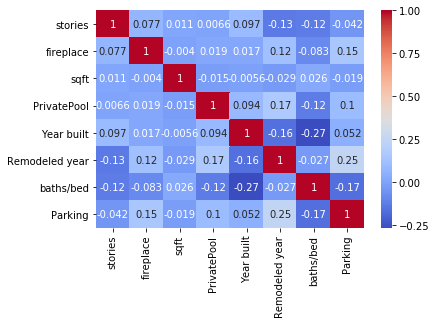

In [100]:
sns.heatmap(Features.corr(), annot=True, cmap='coolwarm')

# Model

In [101]:
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [102]:
scaler = StandardScaler()
FeaturesSt=scaler.fit_transform(Features)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(FeaturesSt, target, test_size=0.2)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (154929, 9)
X_test: (38733, 9)
y_train: (154929,)
y_test: (38733,)


In [ ]:
start = timer()
predictor = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.3)
predictor.fit(X_train, y_train)
y_pred = predictor.predict(X_test)
end = timer()
print(end - start)

In [ ]:
mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)
print(f'R^2 GB: {round(predictor.score(X_test,y_test),4)}, MAE GB: {round(mae,2)},RSME: {round(np.sqrt(mse),2)}')
